In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

# Scikit-learn imports
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:

# For better visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

# Mount Google Drive to access local files
from google.colab import drive
drive.mount('/content/drive')

# Update this path to where your dataset is stored
file_path = '/content/drive/MyDrive/Ames_data/'  # Update this path

# Load the dataset
train_data = pd.read_csv(file_path + 'ames_train.csv')
test_data = pd.read_csv(file_path + 'ames_test.csv')

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# Display the first few rows to understand the data
train_data.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training data shape: (1460, 81)
Testing data shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:

# Define the target variable
if 'SalePrice' in train_data.columns:
    y_train = train_data['SalePrice']
    X_train = train_data.drop('SalePrice', axis=1)
    print(f"Target variable 'SalePrice' found in train data.")
else:
    print("Warning: 'SalePrice' not found in train data.")
    X_train = train_data

# 1a. Identify potentially irrelevant variables based on business understanding


likely_irrelevant = [
    'Id',           # Just an identifier
    'PID',          # Property ID - just an identifier
    'Order',        # If this exists, it's just a sequence number
    'Utilities',    # Most homes likely have similar utilities (low variance)
    'Street',       # Most homes likely on paved streets (low variance)
    'Alley',        # Many homes don't have alleys (high missing values)
    'PoolQC',       # Few homes have pools (high missing values)
    'MiscFeature',  # Miscellaneous features are rare (high missing values)
    'Fence',        # Many homes don't have fences (high missing values)
    'FireplaceQu',  # Many homes don't have fireplaces (high missing values)
]

# Check which of these columns actually exist in our dataset
existing_irrelevant = [col for col in likely_irrelevant if col in X_train.columns]
print(f"Potentially irrelevant columns in dataset: {existing_irrelevant}")

Target variable 'SalePrice' found in train data.
Potentially irrelevant columns in dataset: ['Id', 'Utilities', 'Street', 'Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu']


Columns with >50% missing values: ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType']

Low variance categorical variables (dominant category >95%):
Street: Pave (99.59%)
Utilities: AllPub (99.93%)
Condition2: Norm (98.97%)
RoofMatl: CompShg (98.22%)
Heating: GasA (97.81%)
PoolQC: nan (99.52%)
MiscFeature: nan (96.30%)

Numeric variables with correlation <0.1 with SalePrice: ['PoolArea', 'MoSold', '3SsnPorch', 'BsmtFinSF2', 'BsmtHalfBath', 'MiscVal', 'Id', 'LowQualFinSF', 'YrSold', 'OverallCond', 'MSSubClass']


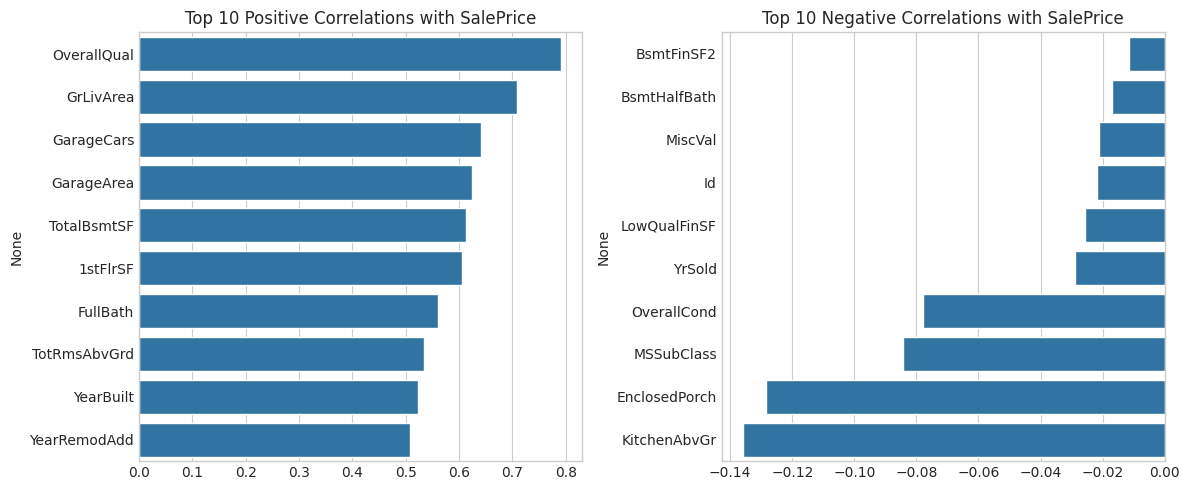

In [5]:
# 1b. Provide statistical evidence to validate irrelevance

# Check for missing values across all columns
missing_values = X_train.isnull().sum().sort_values(ascending=False)
high_missing = missing_values[missing_values/len(X_train) > 0.5].index.tolist()
print(f"Columns with >50% missing values: {high_missing}")

# Check for low variance categorical variables
categorical_cols = X_train.select_dtypes(include=['object']).columns
low_variance_cats = []

for col in categorical_cols:
    value_counts = X_train[col].value_counts(normalize=True, dropna=False)
    if len(value_counts) > 0 and value_counts.iloc[0] > 0.95:
        low_variance_cats.append((col, value_counts.index[0], value_counts.iloc[0]))

print("\nLow variance categorical variables (dominant category >95%):")
for col, category, pct in low_variance_cats:
    print(f"{col}: {category} ({pct:.2%})")

# Calculate correlation with target for numeric columns
if 'SalePrice' in train_data.columns:
    numeric_data = train_data.select_dtypes(include=[np.number])
    correlations = numeric_data.corr()['SalePrice'].sort_values(ascending=False)

    # Identify low correlation variables
    low_corr_vars = correlations[abs(correlations) < 0.1].index.tolist()
    if 'SalePrice' in low_corr_vars:
        low_corr_vars.remove('SalePrice')

    print(f"\nNumeric variables with correlation <0.1 with SalePrice: {low_corr_vars}")

    # Visualize top and bottom correlations side by side
    plt.figure(figsize=(12, 5))

    # Plot top correlations
    plt.subplot(1, 2, 1)
    top_corr = correlations.drop('SalePrice').head(10)
    sns.barplot(x=top_corr.values, y=top_corr.index)
    plt.title('Top 10 Positive Correlations with SalePrice')

    # Plot bottom correlations
    plt.subplot(1, 2, 2)
    bottom_corr = correlations.drop('SalePrice').tail(10)
    sns.barplot(x=bottom_corr.values, y=bottom_corr.index)
    plt.title('Top 10 Negative Correlations with SalePrice')

    plt.tight_layout()
    plt.savefig('correlation_plots.png')

In [6]:

# 1c. Eliminate irrelevant variables based on analysis


# Combine all evidence to create final list of columns to drop
columns_to_drop = list(set(existing_irrelevant + high_missing + low_corr_vars))
for col, _, _ in low_variance_cats:
    if col not in columns_to_drop:
        columns_to_drop.append(col)

# Remove columns that don't exist in the dataset
columns_to_drop = [col for col in columns_to_drop if col in X_train.columns]
print(f"Final list of columns to be eliminated: {columns_to_drop}")

# Drop the irrelevant columns
X_train_reduced = X_train.drop(columns=columns_to_drop, errors='ignore')
if test_data is not None:
    X_test_reduced = test_data.drop(columns=columns_to_drop, errors='ignore')
    if 'SalePrice' in test_data.columns:
        y_test = test_data['SalePrice']
        X_test_reduced = X_test_reduced.drop('SalePrice', axis=1, errors='ignore')

print(f"Dataset shape after removing irrelevant columns: {X_train_reduced.shape}")

Final list of columns to be eliminated: ['PoolQC', 'Fence', 'Utilities', 'OverallCond', 'Alley', 'MasVnrType', 'MiscFeature', 'Street', 'MiscVal', 'PoolArea', '3SsnPorch', 'YrSold', 'BsmtHalfBath', 'LowQualFinSF', 'FireplaceQu', 'BsmtFinSF2', 'MoSold', 'Id', 'MSSubClass', 'Condition2', 'RoofMatl', 'Heating']
Dataset shape after removing irrelevant columns: (1460, 58)



Columns with missing values in reduced dataset:
LotFrontage     259
GarageFinish     81
GarageCond       81
GarageType       81
GarageQual       81
GarageYrBlt      81
BsmtFinType2     38
BsmtExposure     38
BsmtCond         37
BsmtQual         37
BsmtFinType1     37
MasVnrArea        8
Electrical        1
dtype: int64

Columns with outliers:
LotFrontage: 106 outliers
LotArea: 69 outliers
OverallQual: 2 outliers
YearBuilt: 7 outliers
MasVnrArea: 98 outliers
BsmtFinSF1: 7 outliers
BsmtUnfSF: 29 outliers
TotalBsmtSF: 61 outliers
1stFlrSF: 20 outliers
2ndFlrSF: 2 outliers
GrLivArea: 31 outliers
BsmtFullBath: 1 outliers
BedroomAbvGr: 35 outliers


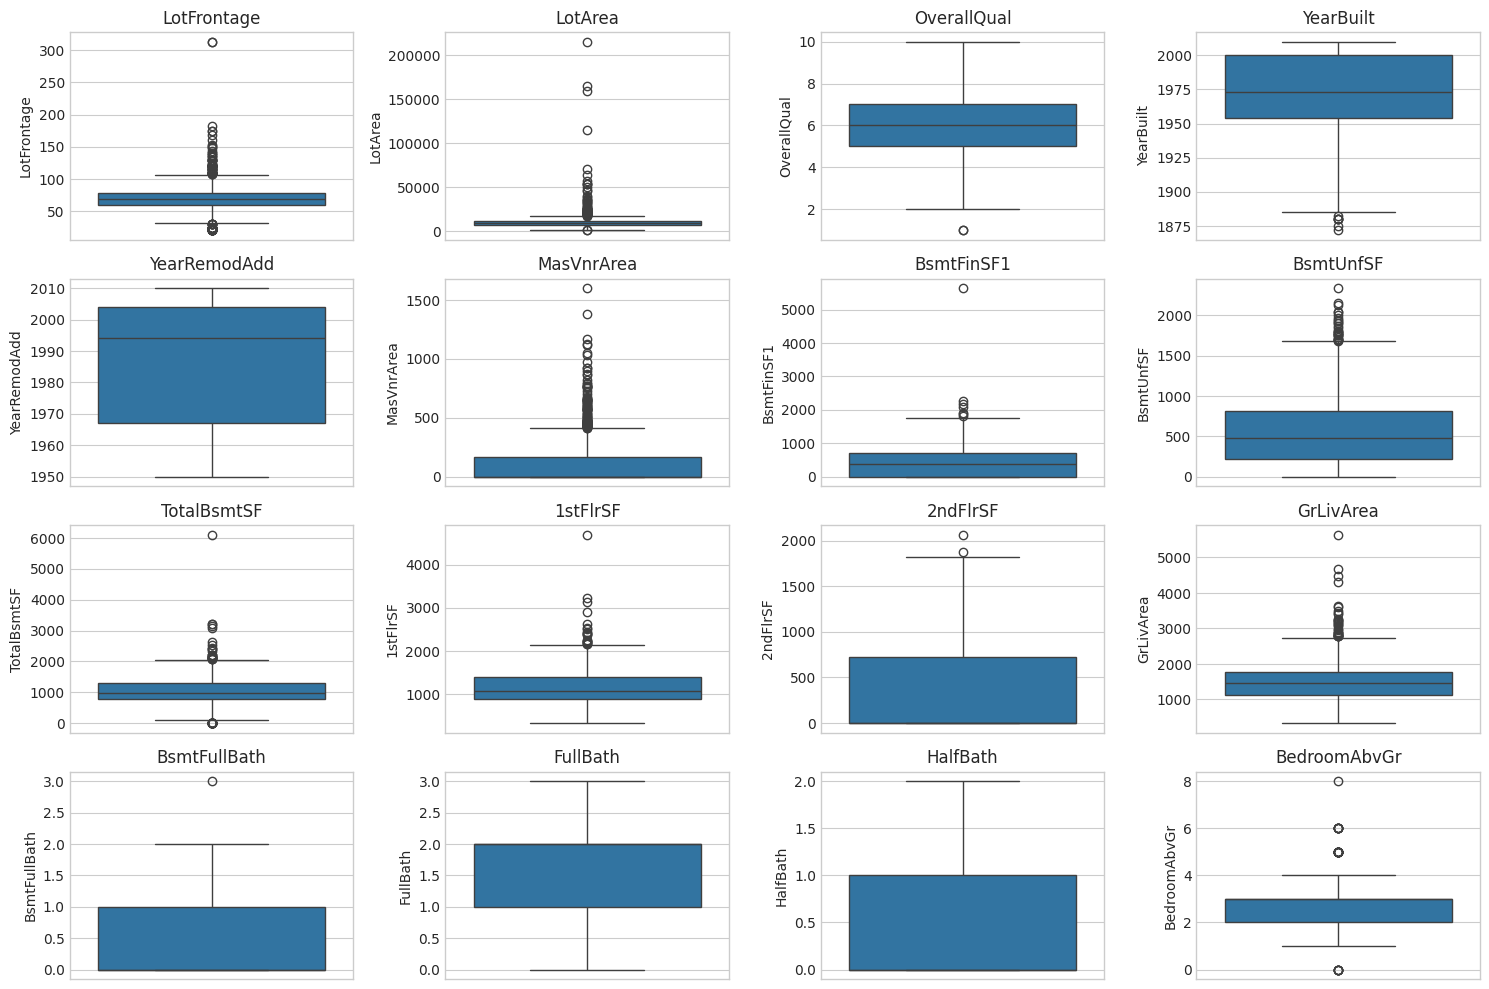

In [7]:

# 2. Data Scaling and Pre-Processing



# Check for missing values in the reduced dataset
missing_values_reduced = X_train_reduced.isnull().sum().sort_values(ascending=False)
missing_values_reduced = missing_values_reduced[missing_values_reduced > 0]
print(f"\nColumns with missing values in reduced dataset:\n{missing_values_reduced}")

# Handle missing values based on data type
for col in X_train_reduced.columns:
    if X_train_reduced[col].isnull().sum() > 0:
        if X_train_reduced[col].dtype == 'object':
            # For categorical columns, fill NA with 'None'
            X_train_reduced[col] = X_train_reduced[col].fillna('None')
            if test_data is not None and col in X_test_reduced.columns:
                X_test_reduced[col] = X_test_reduced[col].fillna('None')
        else:
            # For numerical columns, fill with median
            median_val = X_train_reduced[col].median()
            X_train_reduced[col] = X_train_reduced[col].fillna(median_val)
            if test_data is not None and col in X_test_reduced.columns:
                X_test_reduced[col] = X_test_reduced[col].fillna(median_val)

# Check for outliers in numerical columns
numeric_cols = X_train_reduced.select_dtypes(include=[np.number]).columns
outlier_columns = []

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols[:min(16, len(numeric_cols))]):  # Show first 16 columns
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=X_train_reduced[col])
    plt.title(col)

    # Identify outliers using IQR method
    Q1 = X_train_reduced[col].quantile(0.25)
    Q3 = X_train_reduced[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_count = ((X_train_reduced[col] < (Q1 - 1.5 * IQR)) | (X_train_reduced[col] > (Q3 + 1.5 * IQR))).sum()

    if outlier_count > 0:
        outlier_columns.append((col, outlier_count))

plt.tight_layout()
plt.savefig('outlier_boxplots.png')

print("\nColumns with outliers:")
for col, count in outlier_columns:
    print(f"{col}: {count} outliers")

# Handle outliers by capping at 1% and 99% percentiles
for col in numeric_cols:
    lower_limit = X_train_reduced[col].quantile(0.01)
    upper_limit = X_train_reduced[col].quantile(0.99)

    # Cap outliers
    X_train_reduced[col] = np.where(X_train_reduced[col] < lower_limit, lower_limit, X_train_reduced[col])
    X_train_reduced[col] = np.where(X_train_reduced[col] > upper_limit, upper_limit, X_train_reduced[col])

    # Do the same for test data if available
    if test_data is not None and col in X_test_reduced.columns:
        X_test_reduced[col] = np.where(X_test_reduced[col] < lower_limit, lower_limit, X_test_reduced[col])
        X_test_reduced[col] = np.where(X_test_reduced[col] > upper_limit, upper_limit, X_test_reduced[col])



2b. Feature scaling...

Columns that need scaling:
- LotFrontage
- LotArea
- OverallQual
- YearBuilt
- YearRemodAdd
- MasVnrArea
- BsmtFinSF1
- BsmtUnfSF
- TotalBsmtSF
- 1stFlrSF
- 2ndFlrSF
- GrLivArea
- BsmtFullBath
- FullBath
- HalfBath
- BedroomAbvGr
- KitchenAbvGr
- TotRmsAbvGrd
- Fireplaces
- GarageYrBlt
- GarageCars
- GarageArea
- WoodDeckSF
- OpenPorchSF
- EnclosedPorch
- ScreenPorch

Scaling decision: Using MinMaxScaler for most variables due to:
- Preserves relationships in bounded variables
- Transforms features to [0,1] range which can be useful for algorithms
- Helps with variables where absolute magnitude matters


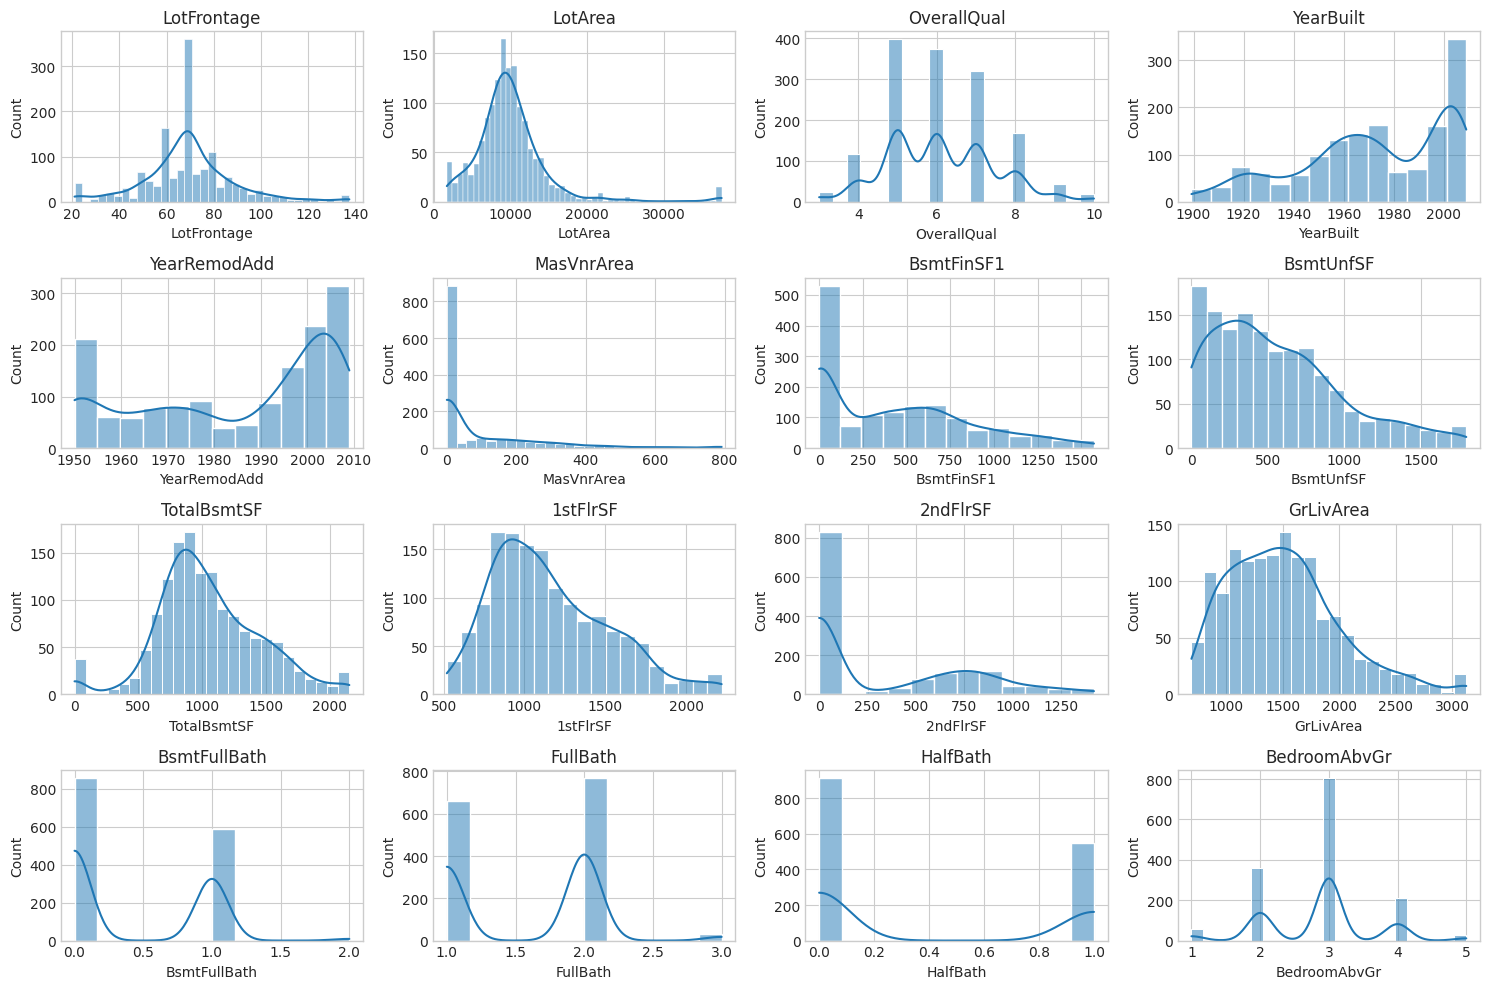

In [8]:

print("\n2b. Feature scaling...")

# Identify columns that need scaling
numeric_cols = X_train_reduced.select_dtypes(include=[np.number]).columns
categorical_cols = X_train_reduced.select_dtypes(include=['object']).columns

# Analyze distributions to decide on scaling technique
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols[:min(16, len(numeric_cols))]):
    plt.subplot(4, 4, i+1)
    sns.histplot(X_train_reduced[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.savefig('distributions.png')

print("\nColumns that need scaling:")
for col in numeric_cols:
    print(f"- {col}")

print("\nScaling decision: Using MinMaxScaler for most variables due to:")
print("- Preserves relationships in bounded variables")
print("- Transforms features to [0,1] range which can be useful for algorithms")
print("- Helps with variables where absolute magnitude matters")

# Create a copy of data for scaling to avoid modifying original
X_train_scaled = X_train_reduced.copy()
if test_data is not None:
    X_test_scaled = X_test_reduced.copy()

# Apply min-max scaling to numeric columns (except special cases)
min_max_scaler = MinMaxScaler()
special_cols = []  # Will handle Pool Area separately
minmax_scale_cols = [col for col in numeric_cols if col not in special_cols]

X_train_scaled[minmax_scale_cols] = min_max_scaler.fit_transform(X_train_reduced[minmax_scale_cols])
if test_data is not None:
    X_test_scaled[minmax_scale_cols] = min_max_scaler.transform(X_test_reduced[minmax_scale_cols])

In [9]:

print("\n2d. Categorical variable encoding...")

# Identify categorical variables
print(f"Categorical variables to encode: {list(categorical_cols)}")

# Group low-frequency categories
for col in categorical_cols:
    value_counts = X_train_reduced[col].value_counts(normalize=True)
    rare_categories = value_counts[value_counts < 0.05].index.tolist()

    if len(rare_categories) > 0:
        print(f"Grouping rare categories in {col}: {rare_categories}")
        X_train_scaled[col] = X_train_reduced[col].apply(lambda x: 'Other' if x in rare_categories else x)
        if test_data is not None and col in X_test_reduced.columns:
            X_test_scaled[col] = X_test_reduced[col].apply(lambda x: 'Other' if x in rare_categories else x)

# Identify ordinal variables (quality, condition ratings)
ordinal_cols = [col for col in categorical_cols if 'Qual' in col or 'Cond' in col or 'QC' in col]
print(f"Ordinal columns to encode with numbers: {ordinal_cols}")

# Encode ordinal variables
ordinal_mapping = {
    'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5,
    'None': 0, 'NA': 0  # For missing values
}

for col in ordinal_cols:
    if col in X_train_scaled.columns:
        X_train_scaled[col] = X_train_scaled[col].map(lambda x: ordinal_mapping.get(x, 0))
        if test_data is not None and col in X_test_scaled.columns:
            X_test_scaled[col] = X_test_scaled[col].map(lambda x: ordinal_mapping.get(x, 0))

# One-hot encode remaining categorical variables
nominal_cols = [col for col in categorical_cols if col not in ordinal_cols]
print(f"Nominal columns for one-hot encoding: {nominal_cols}")

# One-hot encode nominal variables
X_train_encoded = pd.get_dummies(X_train_scaled, columns=nominal_cols, drop_first=True)
if test_data is not None:
    X_test_encoded = pd.get_dummies(X_test_scaled, columns=nominal_cols, drop_first=True)

    # Ensure X_test has the same columns as X_train
    missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
    for col in missing_cols:
        X_test_encoded[col] = 0
    # Keep only columns in X_train
    X_test_encoded = X_test_encoded[X_train_encoded.columns]

print(f"Final dataset shape after encoding: {X_train_encoded.shape}")



2d. Categorical variable encoding...
Categorical variables to encode: ['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
Grouping rare categories in MSZoning: ['FV', 'RH', 'C (all)']
Grouping rare categories in LotShape: ['IR2', 'IR3']
Grouping rare categories in LandContour: ['Bnk', 'HLS', 'Low']
Grouping rare categories in LotConfig: ['FR2', 'FR3']
Grouping rare categories in LandSlope: ['Mod', 'Sev']
Grouping rare categories in Neighborhood: ['SawyerW', 'BrkSide', 'Crawfor', 'Mitchel', 'NoRidge', 'Timber', 'IDOTRR', 'ClearCr', 'SWISU', 'StoneBr', 'Blmngtn', 'MeadowV', 'BrDale', 'Veenker', 'NP

In [10]:

# 3. Data Modelling

print("\n3a. Choosing regression metrics...")
print("For this housing price prediction, we'll use:")
print("- R-squared: To measure overall explanatory power")
print("- RMSE (Root Mean Squared Error): As primary metric since it's in the same units as price")
print("- These metrics are particularly suitable for real estate price prediction")



3a. Choosing regression metrics...
For this housing price prediction, we'll use:
- R-squared: To measure overall explanatory power
- RMSE (Root Mean Squared Error): As primary metric since it's in the same units as price
- These metrics are particularly suitable for real estate price prediction


In [11]:
# Fix for section 3b - OLS implementation with error handling

print("\n3b. Implementing StatsModels OLS with automatic insignificant variable removal...")

# First, check for non-numeric values in the dataset
def check_numeric_issues(df):
    issues = {}
    for col in df.columns:
        if df[col].dtype == 'object':
            issues[col] = "Column has object dtype"
        elif pd.api.types.is_numeric_dtype(df[col]) and not pd.api.types.is_float_dtype(df[col]) and not pd.api.types.is_integer_dtype(df[col]):
            issues[col] = "Column has non-standard numeric dtype"
        elif df[col].isnull().any():
            issues[col] = f"Column has {df[col].isnull().sum()} null values"
    return issues

# Check for issues
print("Checking for data type issues in predictors...")
issues = check_numeric_issues(X_train_encoded)
if issues:
    print("Found issues in the following columns:")
    for col, issue in issues.items():
        print(f"- {col}: {issue}")

    # Fix object dtypes - convert to numeric when possible
    for col in X_train_encoded.columns:
        if X_train_encoded[col].dtype == 'object':
            try:
                X_train_encoded[col] = pd.to_numeric(X_train_encoded[col], errors='coerce')
                print(f"Converted {col} to numeric")
            except:
                print(f"Cannot convert {col} to numeric, dropping column")
                X_train_encoded = X_train_encoded.drop(columns=[col])

    # Fill any remaining nulls with column median
    for col in X_train_encoded.columns:
        if X_train_encoded[col].isnull().any():
            X_train_encoded[col] = X_train_encoded[col].fillna(X_train_encoded[col].median())
            print(f"Filled nulls in {col} with median")

# Check target variable
if not pd.api.types.is_numeric_dtype(y_train):
    print("Target variable is not numeric. Attempting to convert...")
    try:
        y_train = pd.to_numeric(y_train, errors='coerce')
        # Fill any nulls with median
        if y_train.isnull().any():
            y_train = y_train.fillna(y_train.median())
            print("Filled nulls in target variable with median")
    except:
        print("ERROR: Cannot convert target variable to numeric")

# Make a copy for OLS to avoid modifying original
X_train_sm = X_train_encoded.copy()

# Add constant term for intercept
print("Adding constant term...")
try:
    X_train_sm = sm.add_constant(X_train_sm)
    print("Constant term added successfully")
except Exception as e:
    print(f"Error adding constant: {e}")
    # Try alternative method
    X_train_sm['const'] = 1.0
    print("Added constant manually")

# Check for perfect multicollinearity before fitting
print("Checking for perfect multicollinearity...")
try:
    # Calculate correlation matrix
    corr_matrix = X_train_sm.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    perfect_collin = [column for column in upper.columns if any(upper[column] > 0.999)]

    if perfect_collin:
        print(f"Found {len(perfect_collin)} columns with perfect multicollinearity:")
        for col in perfect_collin[:5]:
            print(f"- {col}")
        if len(perfect_collin) > 5:
            print(f"- ... and {len(perfect_collin) - 5} more")

        # Drop these columns
        X_train_sm = X_train_sm.drop(columns=perfect_collin)
        print(f"Dropped {len(perfect_collin)} columns with perfect multicollinearity")
    else:
        print("No perfect multicollinearity detected")
except Exception as e:
    print(f"Error checking multicollinearity: {e}")

# Fit OLS model with robust error handling
print("Fitting initial OLS model...")
try:
    initial_model = sm.OLS(y_train, X_train_sm).fit()
    print("Initial model summary:")
    print(initial_model.summary())
except Exception as e:
    print(f"Error fitting OLS model: {e}")
    print("Trying alternative approach...")

    # Try fitting with sklearn's LinearRegression as fallback
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression().fit(X_train_encoded, y_train)
    print("Fitted with sklearn's LinearRegression instead")
    print(f"R² score: {lr.score(X_train_encoded, y_train):.4f}")

    # Create a placeholder model summary to continue
    print("Cannot produce statsmodels summary. Continuing with basic model.")
    # Set current_model to None to skip p-value based elimination
    current_model = None
    initial_model = None
else:
    current_model = initial_model

# Only proceed with p-value elimination if we have a statsmodels model
if current_model is not None:
    # Automatically remove insignificant variables
    p_value_threshold = 0.05
    print(f"\nRemoving variables with p-value > {p_value_threshold}:")

    while True:
        # Get p-values and find max
        p_values = current_model.pvalues[1:]  # Skip the constant
        if len(p_values) == 0:
            print("No variables left to remove")
            break

        max_p_value = p_values.max()

        # If all p-values are significant, break
        if max_p_value <= p_value_threshold:
            break

        # Remove the variable with the highest p-value
        max_p_value_var = p_values.idxmax()
        print(f"Removing {max_p_value_var} with p-value {max_p_value:.4f}")

        # Drop the variable and refit
        X_train_sm = X_train_sm.drop(max_p_value_var, axis=1)
        try:
            current_model = sm.OLS(y_train, X_train_sm).fit()
        except Exception as e:
            print(f"Error refitting model: {e}")
            break

    print("\nFinal model after removing insignificant variables:")
    print(current_model.summary())

    # Store significant variables for comparison
    significant_vars = [var for var in X_train_sm.columns if var != 'const']
    print(f"Number of significant variables: {len(significant_vars)}")
    final_model = current_model
else:
    # If we couldn't use statsmodels, create a simple list of variables
    significant_vars = list(X_train_encoded.columns)
    print(f"Skipped p-value based elimination. Using all {len(significant_vars)} variables.")

    # Create a basic final model using sklearn
    from sklearn.linear_model import LinearRegression
    final_model = LinearRegression().fit(X_train_encoded, y_train)
    print(f"R² score with all variables: {final_model.score(X_train_encoded, y_train):.4f}")


3b. Implementing StatsModels OLS with automatic insignificant variable removal...
Checking for data type issues in predictors...
Found issues in the following columns:
- MSZoning_RL: Column has non-standard numeric dtype
- MSZoning_RM: Column has non-standard numeric dtype
- LotShape_Other: Column has non-standard numeric dtype
- LotShape_Reg: Column has non-standard numeric dtype
- LandContour_Other: Column has non-standard numeric dtype
- LotConfig_CulDSac: Column has non-standard numeric dtype
- LotConfig_Inside: Column has non-standard numeric dtype
- LotConfig_Other: Column has non-standard numeric dtype
- LandSlope_Other: Column has non-standard numeric dtype
- Neighborhood_Edwards: Column has non-standard numeric dtype
- Neighborhood_Gilbert: Column has non-standard numeric dtype
- Neighborhood_NAmes: Column has non-standard numeric dtype
- Neighborhood_NWAmes: Column has non-standard numeric dtype
- Neighborhood_NridgHt: Column has non-standard numeric dtype
- Neighborhood_Old

In [12]:
print("\n3c. VIF analysis for multicollinearity...")

# Calculate VIF for each variable
vif_data = pd.DataFrame()
X_for_vif = X_train_sm.drop('const', axis=1)

# Now you can print diagnostics on X_for_vif
print(X_for_vif.dtypes)
print(X_for_vif.isna().sum())
print(np.isinf(X_for_vif.select_dtypes(include=np.number)).sum())

# Convert all columns to numeric types
for col in X_for_vif.columns:
    X_for_vif[col] = pd.to_numeric(X_for_vif[col], errors='coerce')

# Drop any columns with non-numeric data that couldn't be converted
numeric_cols = X_for_vif.select_dtypes(include=np.number).columns
if len(numeric_cols) < len(X_for_vif.columns):
    print(f"Warning: Dropped non-numeric columns: {set(X_for_vif.columns) - set(numeric_cols)}")
    X_for_vif = X_for_vif[numeric_cols]

# Fill any NaN values (can happen after coercion)
X_for_vif = X_for_vif.fillna(X_for_vif.mean())

# Check for infinite values and replace them
X_for_vif = X_for_vif.replace([np.inf, -np.inf], np.nan)
X_for_vif = X_for_vif.fillna(X_for_vif.mean())

vif_data["Variable"] = X_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_for_vif.values, i) for i in range(X_for_vif.shape[1])]

print("VIF values:")
print(vif_data.sort_values("VIF", ascending=False).head(10))

# Rest of your code continues...


3c. VIF analysis for multicollinearity...
LotFrontage         float64
LotArea             float64
Condition1            int64
OverallQual         float64
YearBuilt           float64
                     ...   
GarageFinish_Unf       bool
PavedDrive_Other       bool
PavedDrive_Y           bool
SaleType_Other         bool
SaleType_WD            bool
Length: 99, dtype: object
LotFrontage         0
LotArea             0
Condition1          0
OverallQual         0
YearBuilt           0
                   ..
GarageFinish_Unf    0
PavedDrive_Other    0
PavedDrive_Y        0
SaleType_Other      0
SaleType_WD         0
Length: 99, dtype: int64
LotFrontage      0
LotArea          0
Condition1       0
OverallQual      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
ExterQual        0
ExterCond        0
BsmtQual         0
BsmtCond         0
BsmtFinSF1       0
BsmtUnfSF        0
TotalBsmtSF      0
HeatingQC        0
1stFlrSF         0
2ndFlrSF         0
GrLivArea        0
BsmtFullBath  

In [13]:
# First, check data types in your dataframe
print(X_for_vif.dtypes)

# Make sure all variables are numeric
# Convert any object or categorical variables to numeric
X_for_vif_numeric = X_for_vif.select_dtypes(include=['number'])

# Check for missing values
print(X_for_vif_numeric.isnull().sum())

# Now try calculating VIF on clean numeric data with no missing values
X_clean = X_for_vif_numeric.dropna()
vif_data = pd.DataFrame()
vif_data["Variable"] = X_clean.columns
vif_data["VIF"] = [variance_inflation_factor(X_clean.values, i) for i in range(X_clean.shape[1])]

LotFrontage      float64
LotArea          float64
Condition1         int64
OverallQual      float64
YearBuilt        float64
YearRemodAdd     float64
MasVnrArea       float64
ExterQual          int64
ExterCond          int64
BsmtQual           int64
BsmtCond           int64
BsmtFinSF1       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
HeatingQC          int64
1stFlrSF         float64
2ndFlrSF         float64
GrLivArea        float64
BsmtFullBath     float64
FullBath         float64
HalfBath         float64
BedroomAbvGr     float64
KitchenAbvGr     float64
KitchenQual        int64
TotRmsAbvGrd     float64
Fireplaces       float64
GarageYrBlt      float64
GarageCars       float64
GarageArea       float64
GarageQual         int64
GarageCond         int64
WoodDeckSF       float64
OpenPorchSF      float64
EnclosedPorch    float64
ScreenPorch      float64
SaleCondition      int64
dtype: object
LotFrontage      0
LotArea          0
Condition1       0
OverallQual      0
YearBuilt 

In [14]:

X_clean = X_for_vif.copy()

# Clean column names by replacing spaces with underscores
X_clean.columns = [col.replace(' ', '_') for col in X_clean.columns]

# Make sure all columns are numeric
X_clean = X_clean.astype(float)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_clean.columns
vif_data["VIF"] = [variance_inflation_factor(X_clean.values, i) for i in range(X_clean.shape[1])]

# Print results
print(vif_data.sort_values("VIF", ascending=False).head(10))

       Variable         VIF
17    GrLivArea  238.074821
15     1stFlrSF  159.956339
13  TotalBsmtSF   84.993263
16     2ndFlrSF   81.596111
27   GarageCars   41.619415
28   GarageArea   36.347616
4     YearBuilt   34.509761
23  KitchenQual   34.075170
9      BsmtQual   33.617588
30   GarageCond   32.798362



3d. Residual analysis...
Shapiro-Wilk normality test p-value: 0.0000
Residual assumptions assessment:
- Non-normality of residuals detected
Levene test for homoscedasticity p-value: 0.0054
- Heteroscedasticity detected


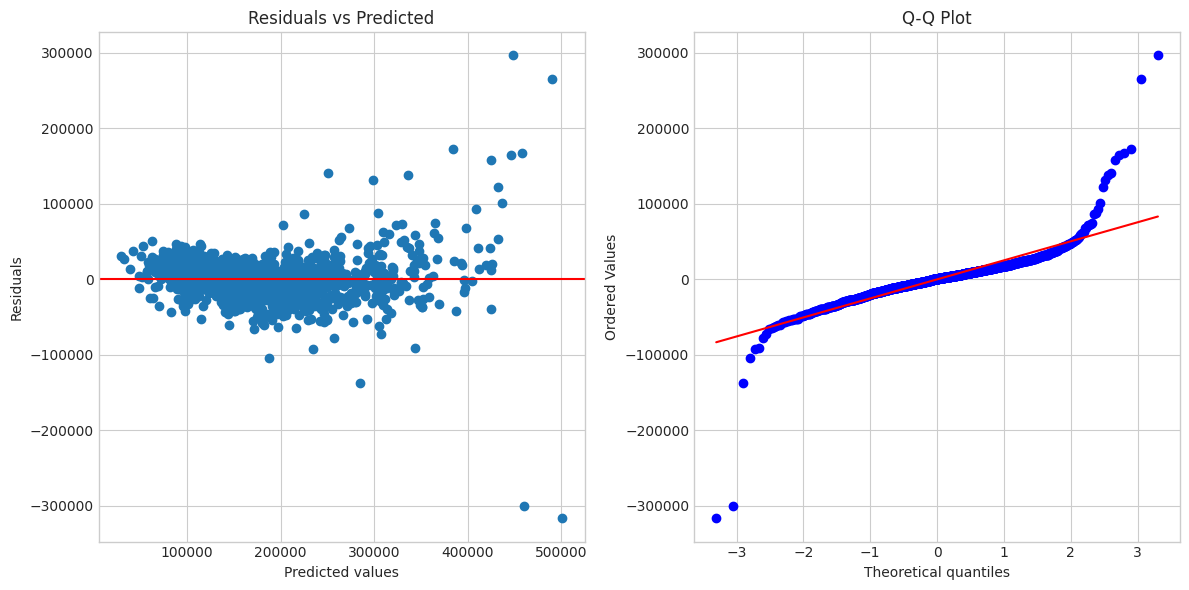

In [15]:
print("\n3d. Residual analysis...")

# Calculate residuals
# Check if the model is from statsmodels or scikit-learn
if hasattr(final_model, 'model'):
    # Statsmodels model
    model_columns = final_model.model.exog_names
    y_pred = final_model.predict(X_train_sm)
else:
    # Scikit-learn model
    model_columns = X_train_encoded.columns
    y_pred = final_model.predict(X_train_encoded)

residuals = y_train - y_pred

# Plot residuals
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Q-Q plot for normality
plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.tight_layout()
plt.savefig('residual_analysis.png')

# Test for normality
_, p_value = stats.shapiro(residuals)
print(f"Shapiro-Wilk normality test p-value: {p_value:.4f}")
print("Residual assumptions assessment:")
if p_value < 0.05:
    print("- Non-normality of residuals detected")
else:
    print("- Residuals appear normally distributed")

# Check for heteroscedasticity
_, p_value = stats.levene(y_pred[:len(y_pred)//2], y_pred[len(y_pred)//2:])
print(f"Levene test for homoscedasticity p-value: {p_value:.4f}")
if p_value < 0.05:
    print("- Heteroscedasticity detected")
else:
    print("- Homoscedasticity assumption appears valid")

In [16]:
# 3e. Gradient-based regressor (continued)
print("\n\n3e. Implementing gradient-based regressor:")

# Use your existing encoded training data
# Assuming X_train_encoded and X_test_encoded exist from earlier in your code
X_for_linear = X_train_encoded.copy()
X_test_for_linear = X_test_encoded.copy() if 'X_test_encoded' in locals() else None

# Initialize and train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_for_linear, y_train)

# Make predictions on training data
y_train_pred_lr = linear_model.predict(X_for_linear)

# Calculate training performance metrics
r2_train_lr = r2_score(y_train, y_train_pred_lr)
mae_train_lr = mean_absolute_error(y_train, y_train_pred_lr)
rmse_train_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))

print("\nLinear Regression (Gradient-based) Performance:")
print(f"Training - R²: {r2_train_lr:.4f}, MAE: ${mae_train_lr:.2f}, RMSE: ${rmse_train_lr:.2f}")

# If validation/test data exists, evaluate on that too
if X_test_for_linear is not None and 'y_test' in locals():
    y_test_pred_lr = linear_model.predict(X_test_for_linear)
    r2_test_lr = r2_score(y_test, y_test_pred_lr)
    mae_test_lr = mean_absolute_error(y_test, y_test_pred_lr)
    rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
    print(f"Test - R²: {r2_test_lr:.4f}, MAE: ${mae_test_lr:.2f}, RMSE: ${rmse_test_lr:.2f}")

# Compare with statsmodels OLS results if available
if 'final_ols_model' in locals() or 'final_model' in locals():
    ols_model = final_ols_model if 'final_ols_model' in locals() else final_model
    if hasattr(ols_model, 'rsquared'):  # Check if it's a statsmodels model
        print("\nComparison of OLS and Gradient-based Linear Regression:")
        print(f"OLS R²: {ols_model.rsquared:.4f}")
        print(f"Gradient-based R²: {r2_train_lr:.4f}")
    else:
        print("\nNote: OLS model comparison not available (not a statsmodels object)")



3e. Implementing gradient-based regressor:

Linear Regression (Gradient-based) Performance:
Training - R²: 0.8687, MAE: $17419.44, RMSE: $28774.88

Note: OLS model comparison not available (not a statsmodels object)




3f. Implementing Lasso regression with different regularization strengths:

Missing values before imputation: 348
Missing values after imputation: 0

Lasso Regression Results with Different Regularization Strengths:
      alpha  non_zero_coefs  train_r2    val_r2
0    0.0001             243  0.936243  0.683272
1    0.0010             243  0.936243  0.683295
2    0.0100             243  0.936243  0.683521
3    0.1000             242  0.936242  0.685775
4    1.0000             241  0.936149  0.707316
5   10.0000             205  0.930850  0.833431
6  100.0000             112  0.902014  0.872576

Best alpha value: 100.0

Number of features selected by Lasso: 112 out of 245

Top 20 most important features according to Lasso:
Neighborhood_StoneBr     38019.106441
Neighborhood_NoRidge     34209.332598
Neighborhood_NridgHt     28595.602388
GrLivArea                26159.146557
OverallQual              19590.638493
Exterior1st_BrkFace      19050.598858
Exterior2nd_ImStucc      18440.434074
S

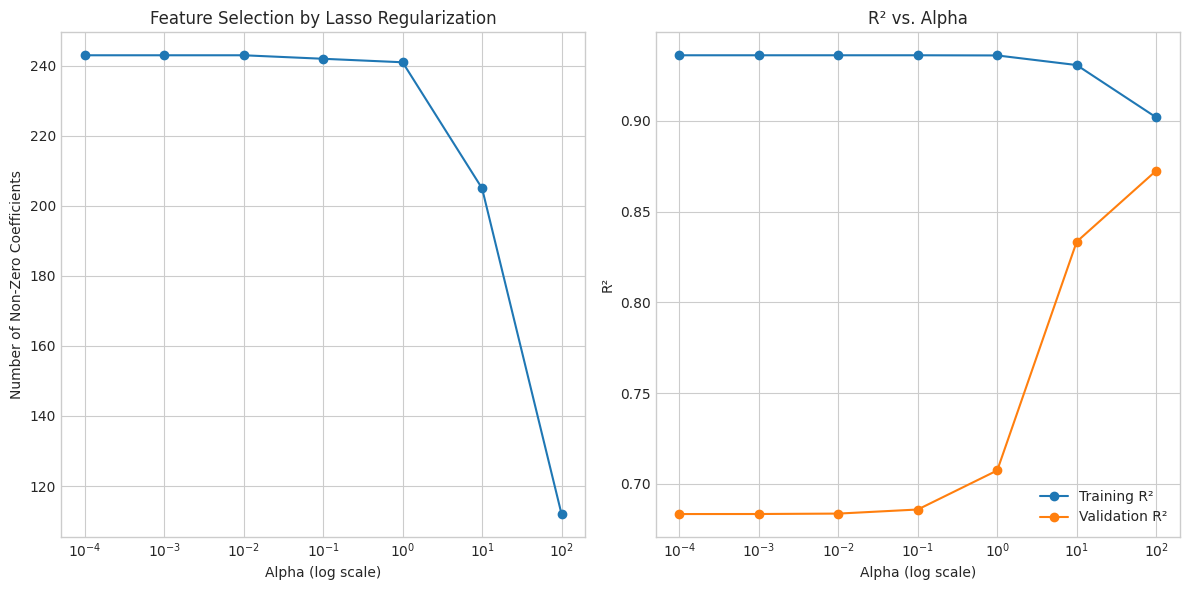

In [17]:
# 3f. Lasso regression with different regularization strengths
print("\n\n3f. Implementing Lasso regression with different regularization strengths:")

# Import any missing libraries
from sklearn.linear_model import Lasso
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer  # Add imputer for missing values
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Prepare data for Lasso regression
# Use your existing training data
X_all = X_train.copy()  # Replace with your actual training data variable
y_all = y_train.copy()  # Use your existing target variable

# Handle categorical variables for Lasso
X_all_encoded = pd.get_dummies(X_all, drop_first=True)

# Check for and handle missing values
print(f"\nMissing values before imputation: {X_all_encoded.isna().sum().sum()}")

# Create an imputer
imputer = SimpleImputer(strategy='median')  # You can also use 'mean' or 'most_frequent'

# Get column types to handle them separately
numeric_features_lasso = X_all_encoded.select_dtypes(include=['int64', 'float64']).columns
categorical_features_lasso = X_all_encoded.select_dtypes(include=['object', 'category', 'bool']).columns

# Impute numeric features
if len(numeric_features_lasso) > 0:
    X_all_encoded[numeric_features_lasso] = imputer.fit_transform(X_all_encoded[numeric_features_lasso])

# Scale numerical features
scaler = RobustScaler()
X_all_encoded[numeric_features_lasso] = scaler.fit_transform(X_all_encoded[numeric_features_lasso])

# Double-check for any remaining NaN values
print(f"Missing values after imputation: {X_all_encoded.isna().sum().sum()}")

# If any NaN values remain, drop those rows or columns
if X_all_encoded.isna().sum().sum() > 0:
    print("Warning: Some NaN values remain. Dropping affected columns...")
    # Drop columns with NaN values
    X_all_encoded = X_all_encoded.dropna(axis=1)
    print(f"Columns remaining after dropping NaNs: {X_all_encoded.shape[1]}")

# Add a constant term for comparison with OLS
X_all_encoded_with_const = sm.add_constant(X_all_encoded)

# Split data
X_train_lasso, X_val_lasso, y_train_lasso, y_val_lasso = train_test_split(
    X_all_encoded, y_all, test_size=0.2, random_state=42
)

# Test different regularization strengths for Lasso
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
results = []

for alpha in alphas:
    # Train Lasso model
    lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    lasso.fit(X_train_lasso, y_train_lasso)

    # Calculate coefficients and number of non-zero coefficients
    coefs = lasso.coef_
    non_zero_coefs = np.sum(coefs != 0)

    # Calculate performance metrics
    train_r2 = r2_score(y_train_lasso, lasso.predict(X_train_lasso))
    val_r2 = r2_score(y_val_lasso, lasso.predict(X_val_lasso))

    results.append({
        'alpha': alpha,
        'non_zero_coefs': non_zero_coefs,
        'train_r2': train_r2,
        'val_r2': val_r2
    })

# Display results
results_df = pd.DataFrame(results)
print("\nLasso Regression Results with Different Regularization Strengths:")
print(results_df)

# Plot number of features vs alpha
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.semilogx(results_df['alpha'], results_df['non_zero_coefs'], 'o-')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Number of Non-Zero Coefficients')
plt.title('Feature Selection by Lasso Regularization')
plt.grid(True)

# Plot R² vs alpha
plt.subplot(1, 2, 2)
plt.semilogx(results_df['alpha'], results_df['train_r2'], 'o-', label='Training R²')
plt.semilogx(results_df['alpha'], results_df['val_r2'], 'o-', label='Validation R²')
plt.xlabel('Alpha (log scale)')
plt.ylabel('R²')
plt.title('R² vs. Alpha')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('lasso_alpha_comparison.png')

# Select the best alpha based on validation performance
best_alpha_idx = results_df['val_r2'].idxmax()
best_alpha = results_df.iloc[best_alpha_idx]['alpha']
print(f"\nBest alpha value: {best_alpha}")

# Train final Lasso model with best alpha
final_lasso = Lasso(alpha=best_alpha, max_iter=10000, random_state=42)
final_lasso.fit(X_train_lasso, y_train_lasso)

# Get non-zero coefficients
feature_names_lasso = X_train_lasso.columns
lasso_coefs = pd.Series(final_lasso.coef_, index=feature_names_lasso)
non_zero_coefs = lasso_coefs[lasso_coefs != 0].sort_values(ascending=False)

print(f"\nNumber of features selected by Lasso: {len(non_zero_coefs)} out of {len(feature_names_lasso)}")
print("\nTop 20 most important features according to Lasso:")
print(non_zero_coefs[:20])

print("\nBottom 20 least important features according to Lasso:")
print(non_zero_coefs[-20:])

# Evaluate final Lasso model performance
y_train_pred_lasso = final_lasso.predict(X_train_lasso)
y_val_pred_lasso = final_lasso.predict(X_val_lasso)

lasso_train_r2 = r2_score(y_train_lasso, y_train_pred_lasso)
lasso_train_mae = mean_absolute_error(y_train_lasso, y_train_pred_lasso)
lasso_train_rmse = np.sqrt(mean_squared_error(y_train_lasso, y_train_pred_lasso))

lasso_val_r2 = r2_score(y_val_lasso, y_val_pred_lasso)
lasso_val_mae = mean_absolute_error(y_val_lasso, y_val_pred_lasso)
lasso_val_rmse = np.sqrt(mean_squared_error(y_val_lasso, y_val_pred_lasso))

print("\nFinal Lasso Model Performance:")
print(f"Training - R²: {lasso_train_r2:.4f}, MAE: ${lasso_train_mae:.2f}, RMSE: ${lasso_train_rmse:.2f}")
print(f"Validation - R²: {lasso_val_r2:.4f}, MAE: ${lasso_val_mae:.2f}, RMSE: ${lasso_val_rmse:.2f}")



2a. Checking for data quality issues:

Columns with missing values:
LotFrontage: 259 missing values (17.74%)
MasVnrType: 872 missing values (59.73%)
MasVnrArea: 8 missing values (0.55%)
BsmtQual: 37 missing values (2.53%)
BsmtCond: 37 missing values (2.53%)
BsmtExposure: 38 missing values (2.60%)
BsmtFinType1: 37 missing values (2.53%)
BsmtFinType2: 38 missing values (2.60%)
Electrical: 1 missing values (0.07%)
FireplaceQu: 690 missing values (47.26%)
GarageType: 81 missing values (5.55%)
GarageYrBlt: 81 missing values (5.55%)
GarageFinish: 81 missing values (5.55%)
GarageQual: 81 missing values (5.55%)
GarageCond: 81 missing values (5.55%)

Number of duplicate rows in training data: 0


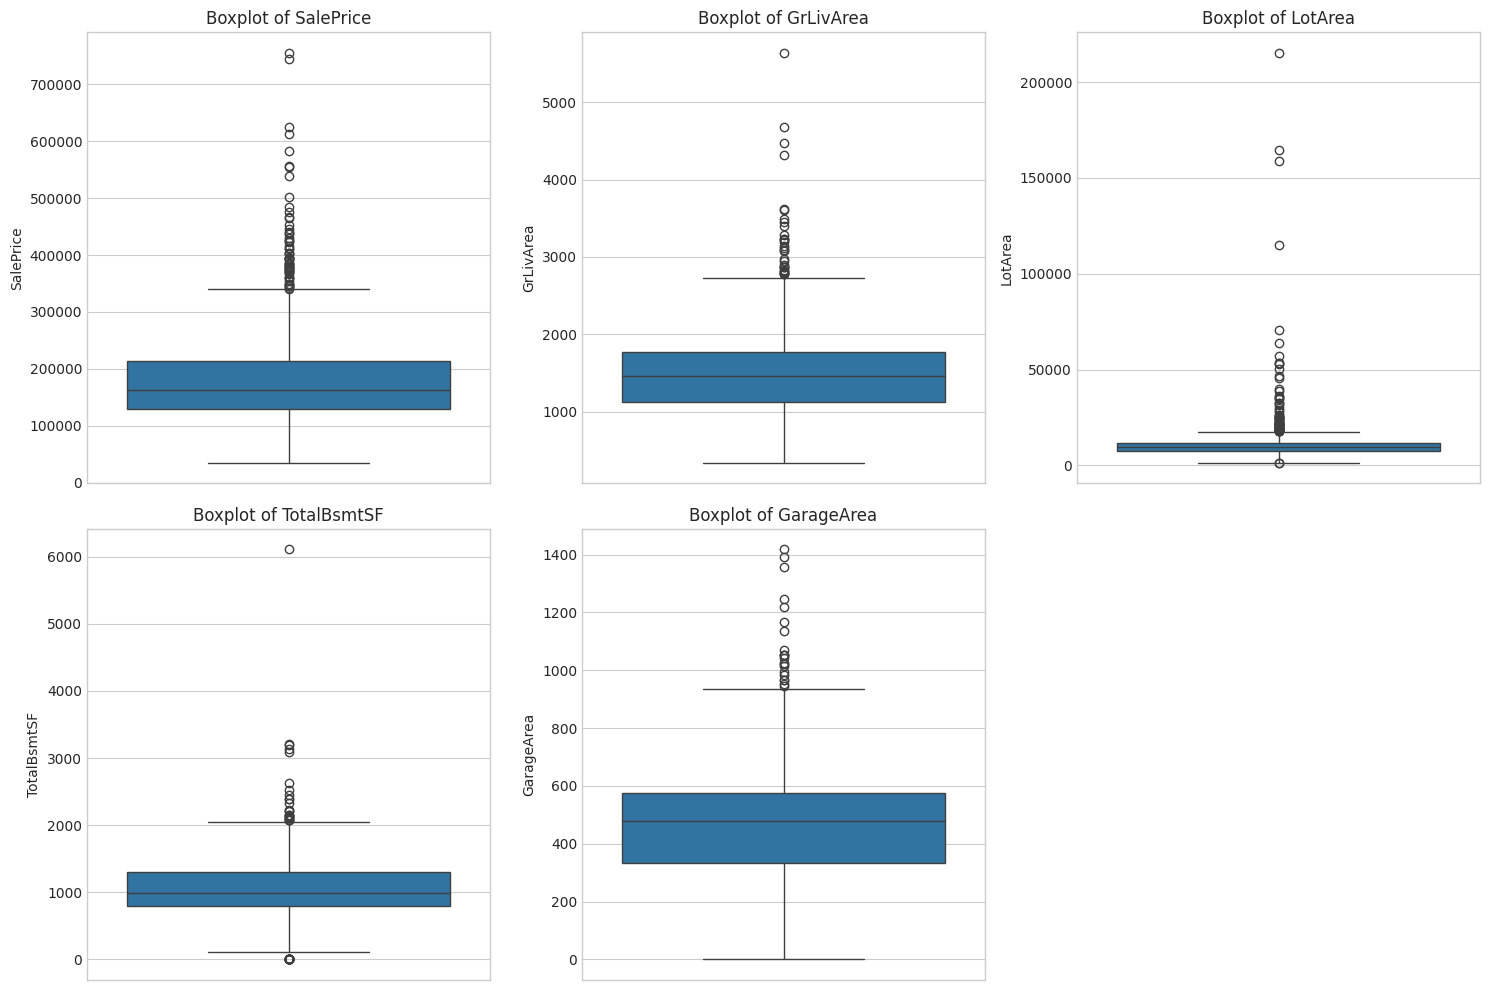

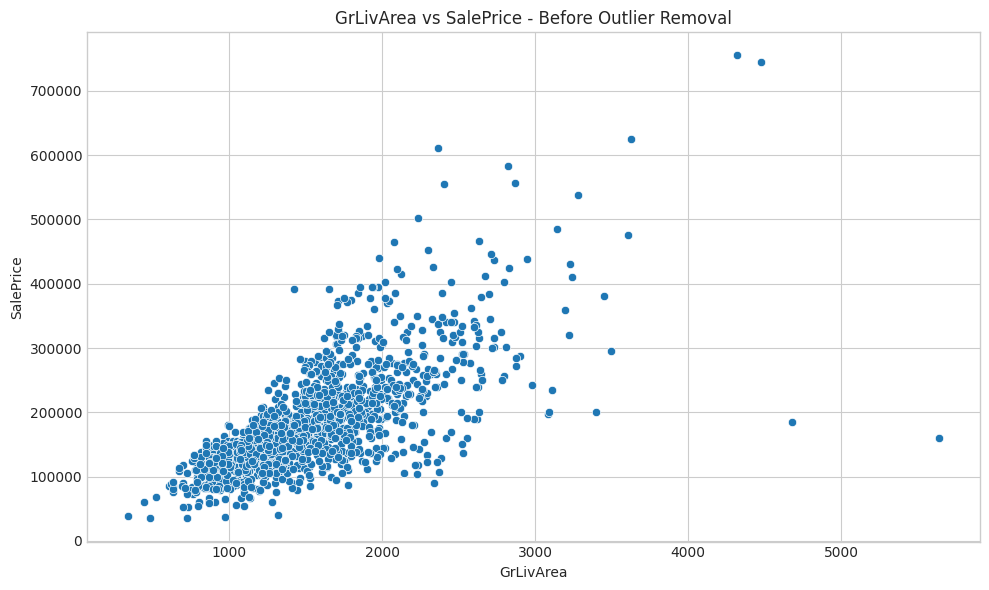


Removed 2 outliers from training data


In [13]:

# ----------------------------------------------------------------
# 2. Data Scaling and Pre-Processing
# ----------------------------------------------------------------

# 2a. Check for missing values, outliers, etc.
print("\n\n2a. Checking for data quality issues:")

# Missing values analysis
missing_values = train_data_cleaned.isnull().sum()
missing_percent = (missing_values / len(train_data_cleaned)) * 100

print("\nColumns with missing values:")
for col, missing in zip(missing_values.index, missing_values):
    if missing > 0:
        percent = missing_percent[col]
        print(f"{col}: {missing} missing values ({percent:.2f}%)")

# Function to fill missing values based on data type and distribution
def fill_missing_values(df):
    df_filled = df.copy()

    # For numeric columns, fill with median
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df_filled[col] = df[col].fillna(df[col].median())

    # For categorical columns, fill with mode
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        if df[col].isnull().sum() > 0:
            df_filled[col] = df[col].fillna(df[col].mode()[0])

    return df_filled

# Apply the missing value treatment
train_data_filled = fill_missing_values(train_data_cleaned)
test_data_filled = fill_missing_values(test_data_cleaned)

# Check for duplicate rows
duplicates = train_data_filled.duplicated().sum()
print(f"\nNumber of duplicate rows in training data: {duplicates}")

# Check for outliers in numeric columns using boxplots for a few key variables
numeric_cols = train_data_filled.select_dtypes(include=['int64', 'float64']).columns
key_numeric_cols = ['SalePrice', 'GrLivArea', 'LotArea', 'TotalBsmtSF', 'GarageArea']

plt.figure(figsize=(15, 10))
for i, col in enumerate(key_numeric_cols):
    if col in train_data_filled.columns:
        plt.subplot(2, 3, i+1)
        sns.boxplot(y=train_data_filled[col])
        plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.savefig('outliers_analysis.png')
plt.show()

# Detecting and handling outliers for GrLivArea - a key predictor of price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_data_filled)
plt.title('GrLivArea vs SalePrice - Before Outlier Removal')
plt.tight_layout()
plt.savefig('GrLivArea_outliers.png')
plt.show()

# Remove extreme outliers in GrLivArea that significantly deviate from the pattern
train_data_no_outliers = train_data_filled[~((train_data_filled['GrLivArea'] > 4000) &
                                           (train_data_filled['SalePrice'] < 300000))]

print(f"\nRemoved {len(train_data_filled) - len(train_data_no_outliers)} outliers from training data")




2b. Determining features for scaling:


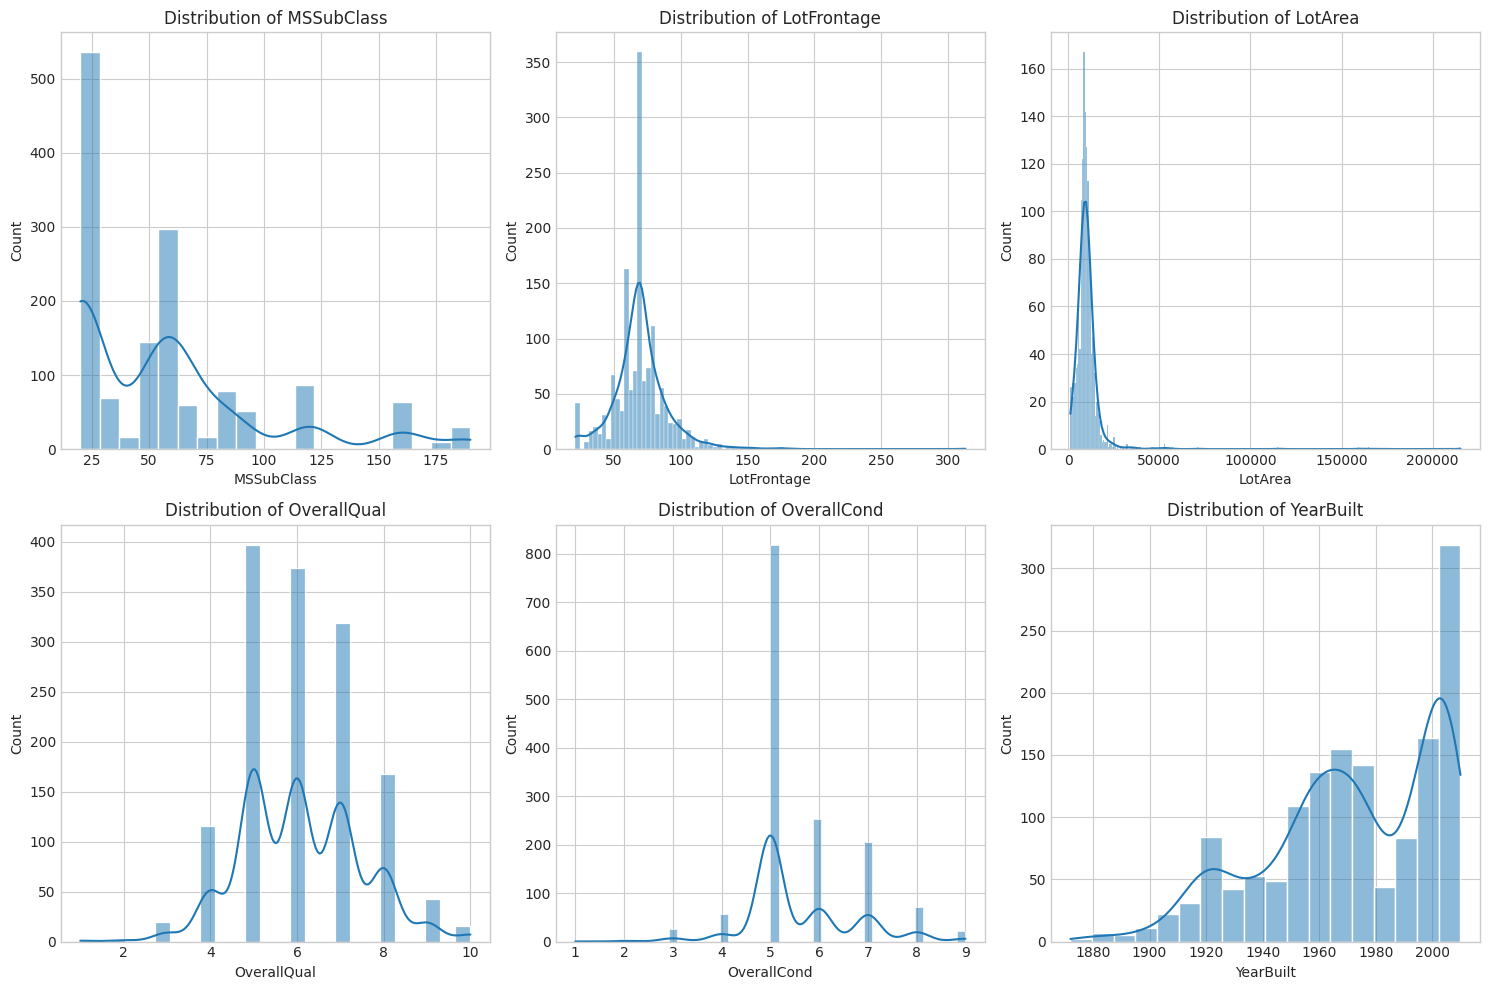


Statistics for numeric features:
                  min       max     range       skew
MSSubClass       20.0     190.0     170.0   1.407011
LotFrontage      21.0     313.0     292.0   1.720857
LotArea        1300.0  215245.0  213945.0  12.573925
OverallQual       1.0      10.0       9.0   0.200786
OverallCond       1.0       9.0       8.0   0.691035
YearBuilt      1872.0    2010.0     138.0  -0.612295
YearRemodAdd   1950.0    2010.0      60.0  -0.501838
MasVnrArea        0.0    1600.0    1600.0   2.696329
BsmtFinSF1        0.0    2188.0    2188.0   0.764789
BsmtFinSF2        0.0    1474.0    1474.0   4.251925
BsmtUnfSF         0.0    2336.0    2336.0   0.920903
TotalBsmtSF       0.0    3206.0    3206.0   0.511703
1stFlrSF        334.0    3228.0    2894.0   0.887637
2ndFlrSF          0.0    2065.0    2065.0   0.812957
LowQualFinSF      0.0     572.0     572.0   9.004955
GrLivArea       334.0    4476.0    4142.0   1.010992
BsmtFullBath      0.0       3.0       3.0   0.590358
BsmtHalfBath

In [14]:

# 2b. Determine which features need scaling and select scaling technique
print("\n\n2b. Determining features for scaling:")

# Separate numeric and categorical columns
numeric_cols = train_data_no_outliers.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = train_data_no_outliers.select_dtypes(include=['object']).columns.tolist()

# Remove the target variable from the numeric columns list
if 'SalePrice' in numeric_cols:
    numeric_cols.remove('SalePrice')

# Check distribution of numeric variables to decide on scaling technique
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols[:6]):  # Just showing first 6 columns
    plt.subplot(2, 3, i+1)
    sns.histplot(train_data_no_outliers[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig('numeric_distributions.png')
plt.show()

# Check the range and skewness of numeric features
numeric_stats = train_data_no_outliers[numeric_cols].describe().T
numeric_stats['skew'] = train_data_no_outliers[numeric_cols].skew()
numeric_stats['range'] = numeric_stats['max'] - numeric_stats['min']

print("\nStatistics for numeric features:")
print(numeric_stats[['min', 'max', 'range', 'skew']])

# Features that might not need scaling due to limited range or categorical-like nature
no_scaling_needed = ['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
                     'MoSold', 'YrSold', 'BsmtFullBath', 'BsmtHalfBath',
                     'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
                     'TotRmsAbvGrd', 'Fireplaces', 'GarageCars']

print("\nFeatures that might not need scaling:")
for col in no_scaling_needed:
    if col in numeric_cols:
        print(f"- {col}")

# Features that need scaling
scaling_needed = [col for col in numeric_cols if col not in no_scaling_needed]

print("\nFeatures that need scaling:")
for col in scaling_needed:
    print(f"- {col}")
